In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, metrics
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import math

In [ ]:
column_names = [
    "Label",                                # 1. Midprice change direction
    "AskPrice_L1", "AskVolume_L1",          # 2–3. Sell level 1
    "BidPrice_L1", "BidVolume_L1",          # 4–5. Buy level 1
    "AskPrice_L2", "AskVolume_L2",          # 6–7. Sell level 2
    "BidPrice_L2", "BidVolume_L2",          # 8–9. Buy level 2
    "AskPrice_L3", "AskVolume_L3",          # 10–11. Sell level 3
    "BidPrice_L3", "BidVolume_L3",          # 12–13. Buy level 3
    "AskPrice_L4", "AskVolume_L4",          # 14–15. Sell level 4
    "BidPrice_L4", "BidVolume_L4",          # 16–17. Buy level 4
    "PrevDir_1", "PrevDir_2", "PrevDir_3", "PrevDir_4", "PrevDir_5"  # 18–22. Previous directions
]

df = pd.read_csv("./DL-2025-CW-data/Data_A.csv", header=None, names=column_names)
df.head()

,Label,AskPrice_L1,AskVolume_L1,BidPrice_L1,BidVolume_L1,AskPrice_L2,AskVolume_L2,BidPrice_L2,BidVolume_L2,AskPrice_L3,...,BidVolume_L3,AskPrice_L4,AskVolume_L4,BidPrice_L4,BidVolume_L4,PrevDir_1,PrevDir_2,PrevDir_3,PrevDir_4,PrevDir_5
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,50,693500.0,50,692500.0,250,0,1,0,1,0
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,328,650700.0,141,649900.0,277,0,0,1,1,1
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,110,636500.0,105,635500.0,201,0,1,0,1,0
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,100,725200.0,379,724100.0,56,1,0,0,1,1
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,249,623200.0,605,622400.0,200,1,0,1,1,0


In [3]:
modified_df = df.copy()
modified_df["midprice"] = (df["AskPrice_L1"] + df["BidPrice_L1"]) / 2
for i in range(1,5):
    modified_df[f"PriceSpread_L{i}"] = df[f"AskPrice_L{i}"] - df[f"BidPrice_L{i}"]
    modified_df[f"RelativeSpread_L{i}"] = (modified_df[f"PriceSpread_L{i}"] / modified_df[f'midprice']) * 100
    modified_df[f'VolumeImbalance_L{i}'] = (df[f'BidVolume_L{i}'] - df[f'AskVolume_L{i}']) / (df[f'BidVolume_L{i}'] + df[f'AskVolume_L{i}'])

modified_df.head()


,Label,AskPrice_L1,AskVolume_L1,BidPrice_L1,BidVolume_L1,AskPrice_L2,AskVolume_L2,BidPrice_L2,BidVolume_L2,AskPrice_L3,...,VolumeImbalance_L1,PriceSpread_L2,RelativeSpread_L2,VolumeImbalance_L2,PriceSpread_L3,RelativeSpread_L3,VolumeImbalance_L3,PriceSpread_L4,RelativeSpread_L4,VolumeImbalance_L4
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,-0.067797,600.0,0.086580,0.534884,800.0,0.115440,-0.651568,1000.0,0.144300,0.666667
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,-0.650741,400.0,0.061510,0.027778,600.0,0.092265,0.378151,800.0,0.123020,0.325359
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,-0.009901,600.0,0.094340,-0.739130,800.0,0.125786,-0.153846,1000.0,0.157233,0.313725
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,0.555556,600.0,0.082799,0.723757,900.0,0.124198,-0.200000,1100.0,0.151797,-0.742529
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,-0.047619,400.0,0.064226,-0.270960,600.0,0.096339,-0.275109,800.0,0.128452,-0.503106


In [4]:
modified_df.size

7000000

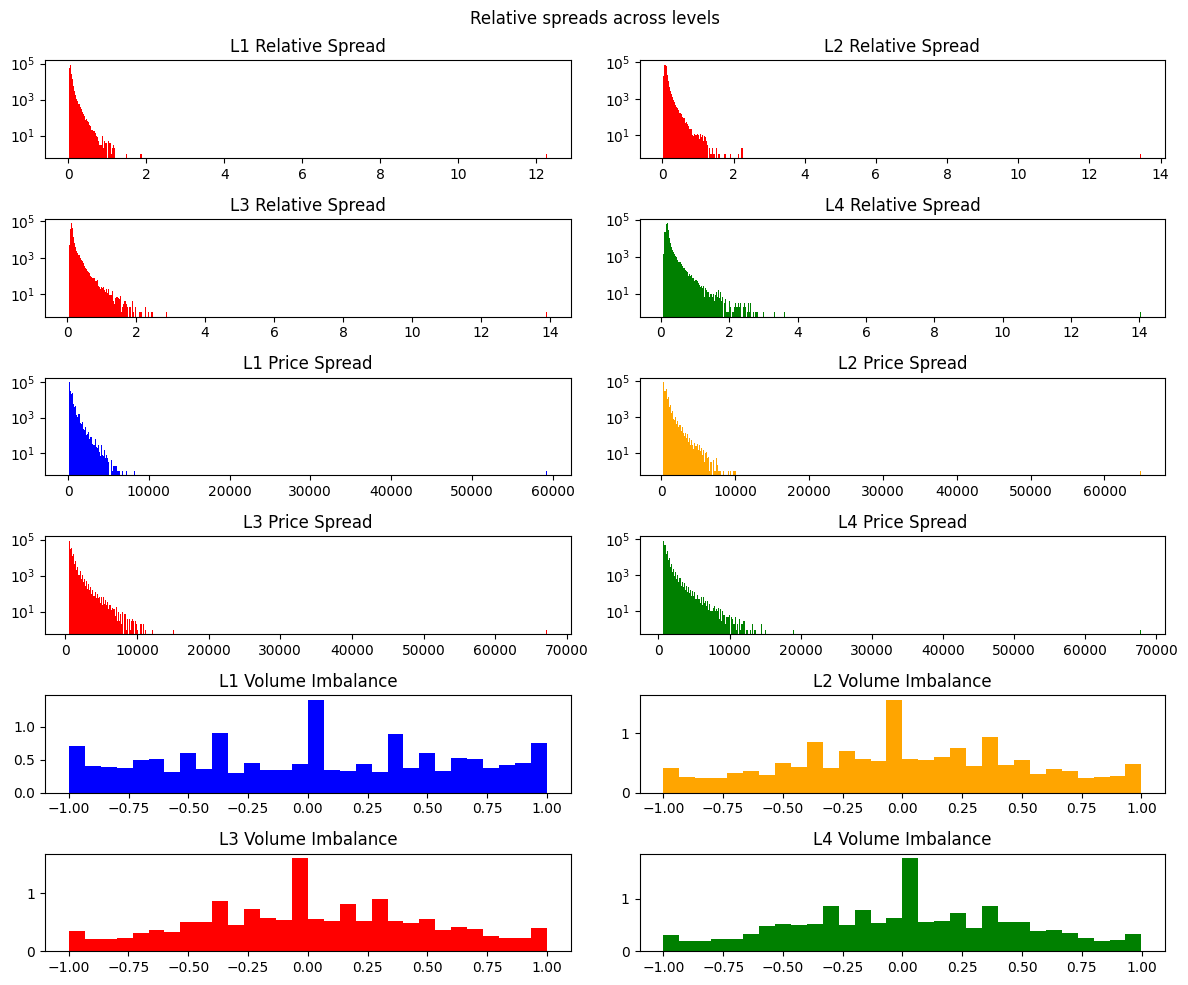

In [ ]:
num_bins = int(math.sqrt(200_000))

fig, axs = plt.subplots(6,2, figsize=(12,10))

# ------------------------- RELATIVE SPREADS ---------------------- #

axs[0,0].hist(modified_df[f'RelativeSpread_L1'], bins=num_bins, color="Red")
axs[0,0].set_yscale('log')
#axs[1,0].set_xlim(0, 4)
axs[0,0].set_title('L1 Relative Spread')

axs[0,1].hist(modified_df[f'RelativeSpread_L2'], bins=num_bins, color="Red")
axs[0,1].set_yscale('log')
#axs[1,0].set_xlim(0, 4)
axs[0,1].set_title('L2 Relative Spread')

axs[1,0].hist(modified_df[f'RelativeSpread_L3'], bins=num_bins, color="Red")
axs[1,0].set_yscale('log')
#axs[1,0].set_xlim(0, 4)
axs[1,0].set_title('L3 Relative Spread')

axs[1,1].hist(modified_df[f'RelativeSpread_L4'], bins=num_bins, color="Green")
axs[1,1].set_yscale('log')
#axs[1,1].set_xlim(0, 4)
axs[1,1].set_title('L4 Relative Spread')

# ------------------------- PRICE SPREADS ---------------------- #

axs[2,0].hist(modified_df[f'PriceSpread_L1'], bins=num_bins, color="Blue")
axs[2,0].set_yscale('log')
#axs[2,0].set_xlim(0, 8_000)
axs[2,0].set_title('L1 Price Spread')

axs[2,1].hist(modified_df[f'PriceSpread_L2'], bins=num_bins, color="Orange")
axs[2,1].set_yscale('log')
#axs[2,1].set_xlim(0, 8_000)
axs[2,1].set_title('L2 Price Spread')

axs[3,0].hist(modified_df[f'PriceSpread_L3'], bins=num_bins, color="Red")
axs[3,0].set_yscale('log')
#axs[3,0].set_xlim(0, 20_000)
axs[3,0].set_title('L3 Price Spread')

axs[3,1].hist(modified_df[f'PriceSpread_L4'], bins=num_bins, color="Green")
axs[3,1].set_yscale('log')
#axs[3,1].set_xlim(0, 20_000)
axs[3,1].set_title('L4 Price Spread')

# ------------------------- IMBALANCES ---------------------- #

axs[4,0].hist(modified_df[f'VolumeImbalance_L1'], bins=30, color="Blue", density=True)
axs[4,0].set_title('L1 Volume Imbalance')

axs[4,1].hist(modified_df[f'VolumeImbalance_L2'], bins=30, color="Orange", density=True)
axs[4,1].set_title('L2 Volume Imbalance')

axs[5,0].hist(modified_df[f'VolumeImbalance_L3'], bins=30, color="Red", density=True)
axs[5,0].set_title('L3 Volume Imbalance')

axs[5,1].hist(modified_df[f'VolumeImbalance_L4'], bins=30, color="Green", density=True)
axs[5,1].set_title('L4 Volume Imbalance')


plt.suptitle("Relative spreads across levels")
plt.tight_layout()

We can see there's one pretty extreme outlier. For purposes of training, we're gonna remove this row as it won't contribute anything to the model:

In [6]:
modified_df = modified_df[modified_df['PriceSpread_L1'] < 40_000]
modified_df.size

6999965

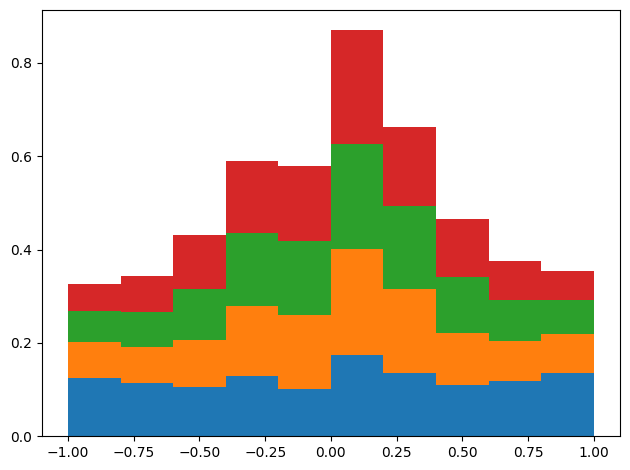

In [7]:
vol_imbalances = [modified_df[f'VolumeImbalance_L1'], modified_df[f'VolumeImbalance_L2'], 
                  modified_df[f'VolumeImbalance_L3'], modified_df[f'VolumeImbalance_L4']]
plt.hist(vol_imbalances, stacked=True, density=True)
plt.tight_layout()

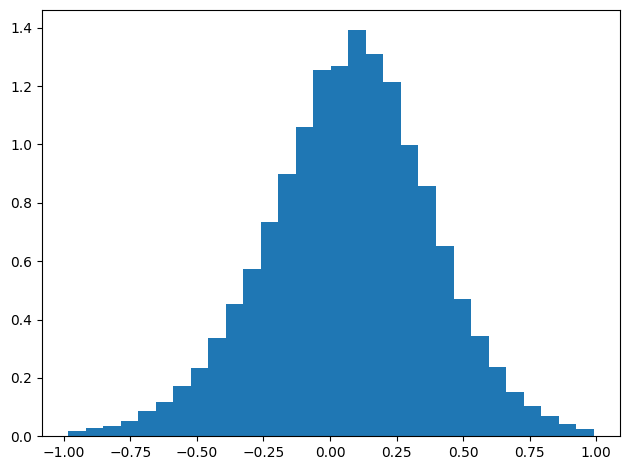

In [ ]:
# ------------------------- ORDER BOOK PRESSURE ---------------------- #

bid_vol_cols = [f"BidVolume_L{i}" for i in range(1, 5)]
ask_vol_cols = [f"AskVolume_L{i}" for i in range(1, 5)]

modified_df["TotalBidVol"] = df[bid_vol_cols].sum(axis=1)
modified_df["TotalAskVol"] = df[ask_vol_cols].sum(axis=1)

modified_df["OrderBookPressure"] = (
    (modified_df["TotalBidVol"] - modified_df["TotalAskVol"]) /
    (modified_df["TotalBidVol"] + modified_df["TotalAskVol"])
)

# Replace potential division by zero with 0 (neutral pressure)
modified_df["OrderBookPressure"] = modified_df["OrderBookPressure"].fillna(0)

plt.hist(modified_df.loc[modified_df["Label"] == 1, "OrderBookPressure"], bins=30, density=True)
plt.tight_layout()



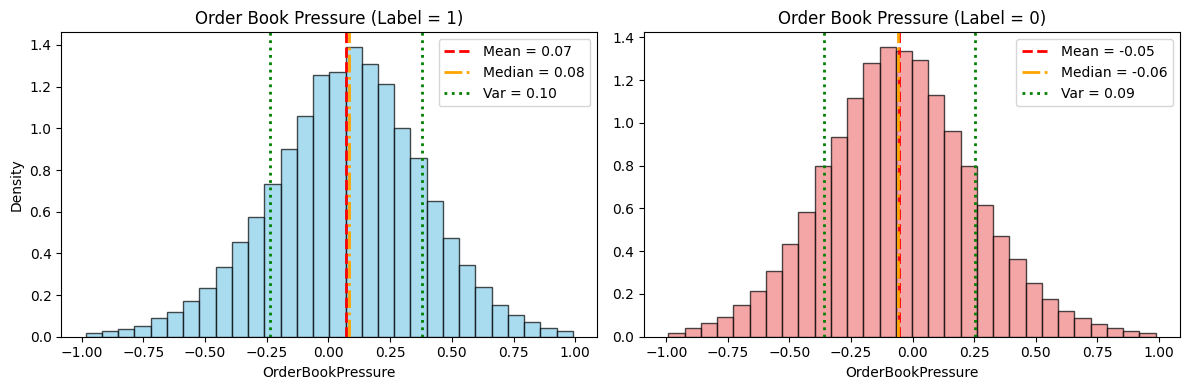

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# --- Label = 1 ---
data1 = modified_df.loc[modified_df["Label"] == 1, "OrderBookPressure"]
axs[0].hist(data1, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)

axs[0].axvline(data1.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {data1.mean():.2f}")
axs[0].axvline(data1.median(), color='orange', linestyle='-.', linewidth=2, label=f"Median = {data1.median():.2f}")

axs[0].axvline(data1.mean() + data1.var()**0.5, color='green', linestyle=':', linewidth=2, label=f"Var = {data1.var():.2f}")
axs[0].axvline(data1.mean() - data1.var()**0.5, color='green', linestyle=':', linewidth=2)

axs[0].set_title("Order Book Pressure (Label = 1)")
axs[0].set_xlabel("OrderBookPressure")
axs[0].set_ylabel("Density")
axs[0].legend()

# --- Label = 0 ---
data0 = modified_df.loc[modified_df["Label"] == 0, "OrderBookPressure"]
axs[1].hist(data0, bins=30, density=True, color='lightcoral', edgecolor='black', alpha=0.7)

axs[1].axvline(data0.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {data0.mean():.2f}")
axs[1].axvline(data0.median(), color='orange', linestyle='-.', linewidth=2, label=f"Median = {data0.median():.2f}")

axs[1].axvline(data0.mean() + data0.var()**0.5, color='green', linestyle=':', linewidth=2, label=f"Var = {data0.var():.2f}")
axs[1].axvline(data0.mean() - data0.var()**0.5, color='green', linestyle=':', linewidth=2)

axs[1].set_title("Order Book Pressure (Label = 0)")
axs[1].set_xlabel("OrderBookPressure")
axs[1].legend()

plt.tight_layout()
plt.show()



### New Feature: Weighted Order Book Pressure.

#### The aim of the weighted OB pressure feature is to capture directional pressure accross levels, giving a higher importance to Level 1 vs levels 2 to 4. Rationale: 

- Level 1 (best bid/ask) has the highest probability of execution, most relevant
- Deeper levels (L2-L4) are less likely to execute immediately, indicating less predictive power

In [10]:
weights = [0.6, 0.25, 0.1, 0.05]  # Level 1 most important
modified_df["WeightedBidVol"] = sum(modified_df[f"BidVolume_L{i}"] * w for i, w in enumerate(weights, 1))
modified_df["WeightedAskVol"] = sum(modified_df[f"AskVolume_L{i}"] * w for i, w in enumerate(weights, 1))

modified_df["WeightedOBPressure"] = (
    (modified_df["WeightedBidVol"] - modified_df["WeightedAskVol"]) /
    (modified_df["WeightedBidVol"] + modified_df["WeightedAskVol"])
).fillna(0)

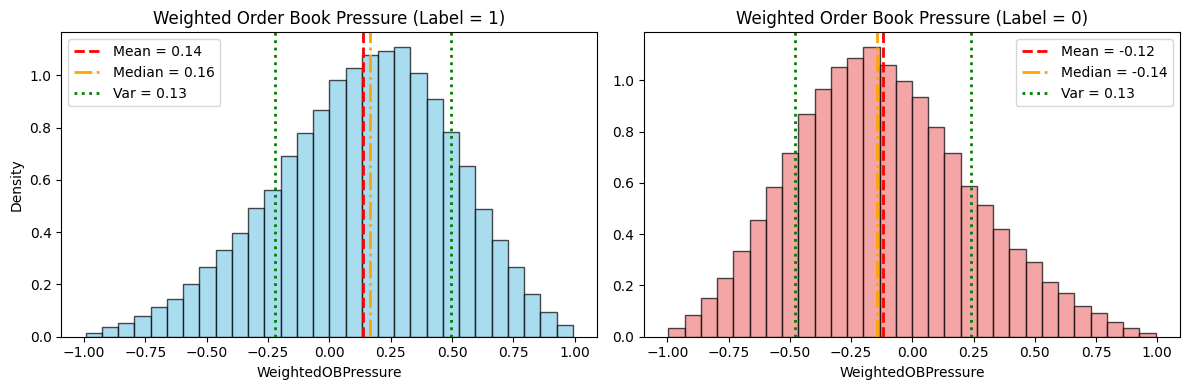

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# --- Label = 1 ---
data1 = modified_df.loc[modified_df["Label"] == 1, "WeightedOBPressure"]
axs[0].hist(data1, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
axs[0].axvline(data1.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {data1.mean():.2f}")
axs[0].axvline(data1.median(), color='orange', linestyle='-.', linewidth=2, label=f"Median = {data1.median():.2f}")
axs[0].axvline(data1.mean() + data1.var()**0.5, color='green', linestyle=':', linewidth=2, label=f"Var = {data1.var():.2f}")
axs[0].axvline(data1.mean() - data1.var()**0.5, color='green', linestyle=':', linewidth=2)
axs[0].set_title("Weighted Order Book Pressure (Label = 1)")
axs[0].set_xlabel("WeightedOBPressure")
axs[0].set_ylabel("Density")
axs[0].legend()

# --- Label = 0 ---
data0 = modified_df.loc[modified_df["Label"] == 0, "WeightedOBPressure"]
axs[1].hist(data0, bins=30, density=True, color='lightcoral', edgecolor='black', alpha=0.7)
axs[1].axvline(data0.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {data0.mean():.2f}")
axs[1].axvline(data0.median(), color='orange', linestyle='-.', linewidth=2, label=f"Median = {data0.median():.2f}")
axs[1].axvline(data0.mean() + data0.var()**0.5, color='green', linestyle=':', linewidth=2, label=f"Var = {data0.var():.2f}")
axs[1].axvline(data0.mean() - data0.var()**0.5, color='green', linestyle=':', linewidth=2)
axs[1].set_title("Weighted Order Book Pressure (Label = 0)")
axs[1].set_xlabel("WeightedOBPressure")
axs[1].legend()

plt.tight_layout()
plt.show()

#### We can create some more additional features:

In [12]:
# ----------------- Volume-Based Features (Cleaned & Explained) ----------------- #

# Use total bid/ask volumes already computed earlier for consistency
total_bid_volume = modified_df["TotalBidVol"]
total_ask_volume = modified_df["TotalAskVol"]

# 1. Depth Imbalance (cumulative)
# Measures how buying vs selling pressure evolves deeper in the book.
# A positive value indicates stronger cumulative bid-side liquidity up to that level.
for k in range(1, 5):
    cum_bid = sum([modified_df[f'BidVolume_L{level}'] for level in range(1, k+1)])
    cum_ask = sum([modified_df[f'AskVolume_L{level}'] for level in range(1, k+1)])
    modified_df[f'DepthImbalance_L{k}'] = (cum_bid - cum_ask) / (cum_bid + cum_ask)

# 2. Bid/Ask Volume Ratio
# Captures overall dominance of bid vs ask liquidity across all levels.
# High values suggest buying interest outweighs selling pressure.
modified_df['BidAskVolumeRatio'] = total_bid_volume / total_ask_volume

# 3. Volume Concentration
# Indicates how much of total liquidity is concentrated near the top of the book.
# Higher concentration at Level 1 or 1+2 implies tighter liquidity near best prices.
modified_df['BidVolumeConcentration_L1'] = modified_df['BidVolume_L1'] / total_bid_volume
modified_df['AskVolumeConcentration_L1'] = modified_df['AskVolume_L1'] / total_ask_volume
bid_vol_12 = modified_df['BidVolume_L1'] + modified_df['BidVolume_L2']
ask_vol_12 = modified_df['AskVolume_L1'] + modified_df['AskVolume_L2']
modified_df['BidVolumeConcentration_L12'] = bid_vol_12 / total_bid_volume
modified_df['AskVolumeConcentration_L12'] = ask_vol_12 / total_ask_volume

# 4: Depth and liquidity indicators
# Provide absolute liquidity measures in the order book.
# TotalDepth reflects overall market depth; BidDepth/AskDepth isolate each side.
modified_df['TotalDepth'] = total_bid_volume + total_ask_volume
modified_df['BidDepth'] = total_bid_volume
modified_df['AskDepth'] = total_ask_volume

# 5: Volume decay, ratios, averages, and variability
# VolumeDecay measures how quickly liquidity thins out from Level 1 to Level 4.
# VolumeRatios show the relative change between adjacent levels.
# AvgVolume and Std quantify the mean and dispersion of volume distribution.
modified_df['BidVolumeDecay'] = (modified_df['BidVolume_L1'] - modified_df['BidVolume_L4']) / modified_df['BidVolume_L1']
modified_df['AskVolumeDecay'] = (modified_df['AskVolume_L1'] - modified_df['AskVolume_L4']) / modified_df['AskVolume_L1']
for level in range(1, 4):
    modified_df[f'BidVolumeRatio_L{level}_L{level+1}'] = modified_df[f'BidVolume_L{level}'] / modified_df[f'BidVolume_L{level+1}']
    modified_df[f'AskVolumeRatio_L{level}_L{level+1}'] = modified_df[f'AskVolume_L{level}'] / modified_df[f'AskVolume_L{level+1}']
modified_df['AvgBidVolume'] = total_bid_volume / 4
modified_df['AvgAskVolume'] = total_ask_volume / 4
bid_volumes_array = np.array([modified_df[f'BidVolume_L{level}'] for level in range(1, 5)])
ask_volumes_array = np.array([modified_df[f'AskVolume_L{level}'] for level in range(1, 5)])
modified_df['BidVolumeStd'] = np.std(bid_volumes_array, axis=0)
modified_df['AskVolumeStd'] = np.std(ask_volumes_array, axis=0)

# 6: Volume Slope (Level 4 - Level 1) / 3
# Approximates the slope of the order book depth curve between L1 and L4.
# Positive slope indicates increasing liquidity deeper in the book; negative suggests concentration near top levels.
modified_df['BidVolumeSlope'] = (modified_df['BidVolume_L4'] - modified_df['BidVolume_L1']) / 3
modified_df['AskVolumeSlope'] = (modified_df['AskVolume_L4'] - modified_df['AskVolume_L1']) / 3


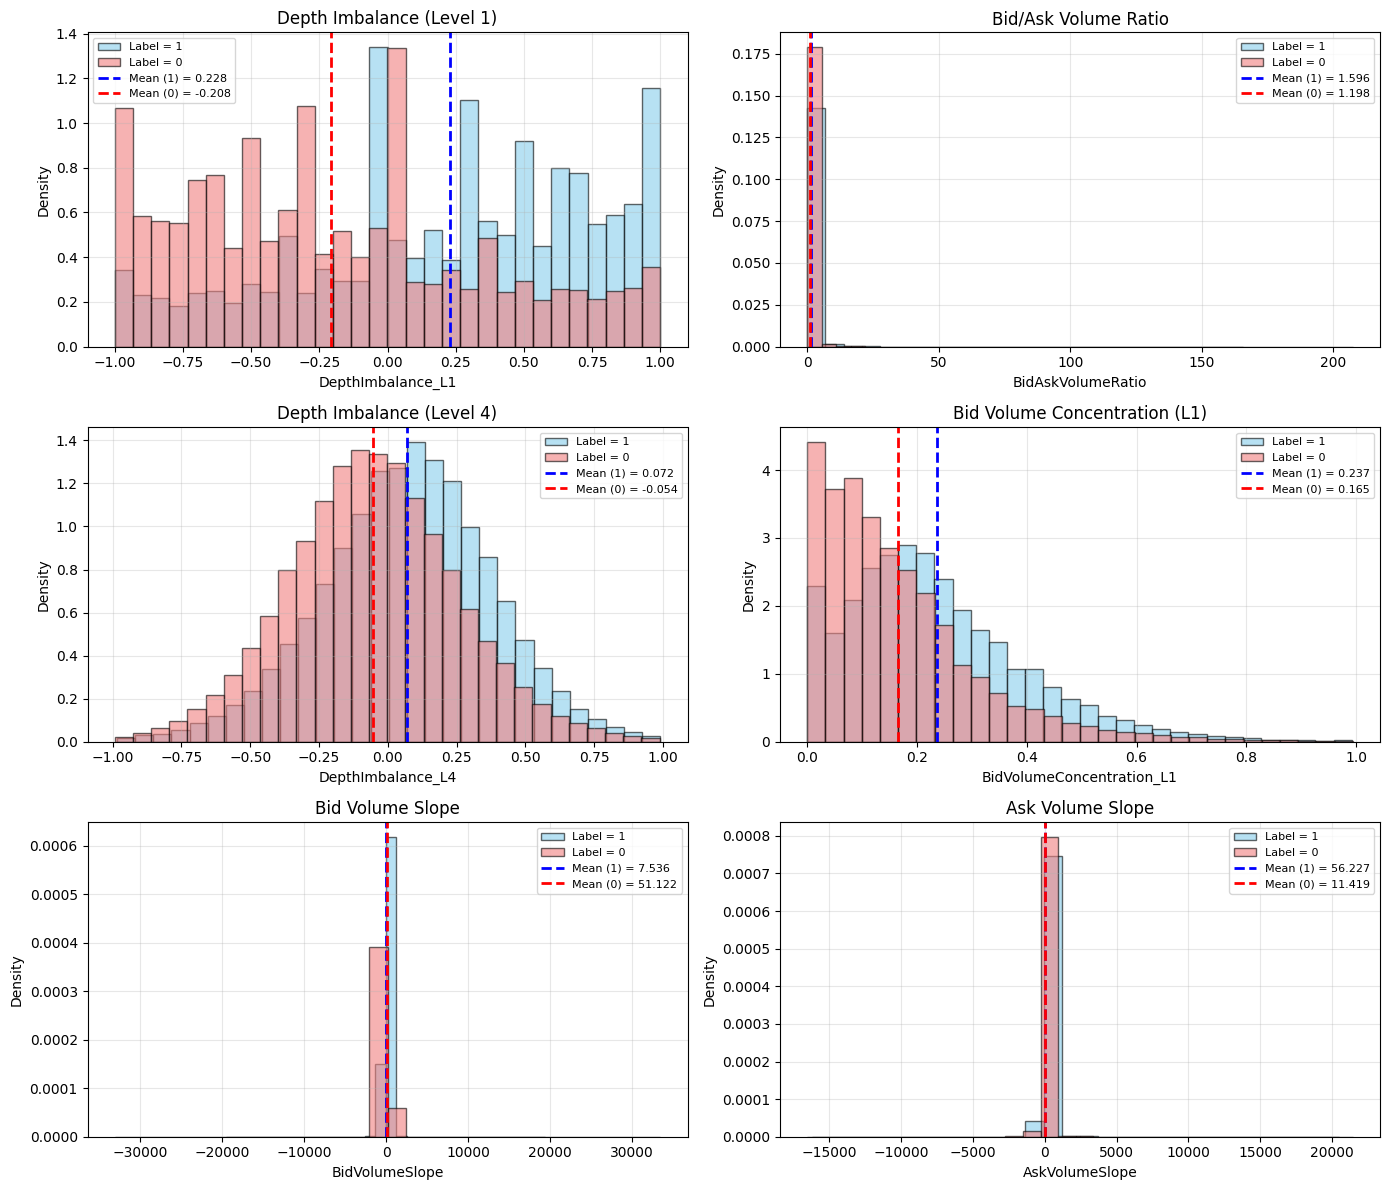

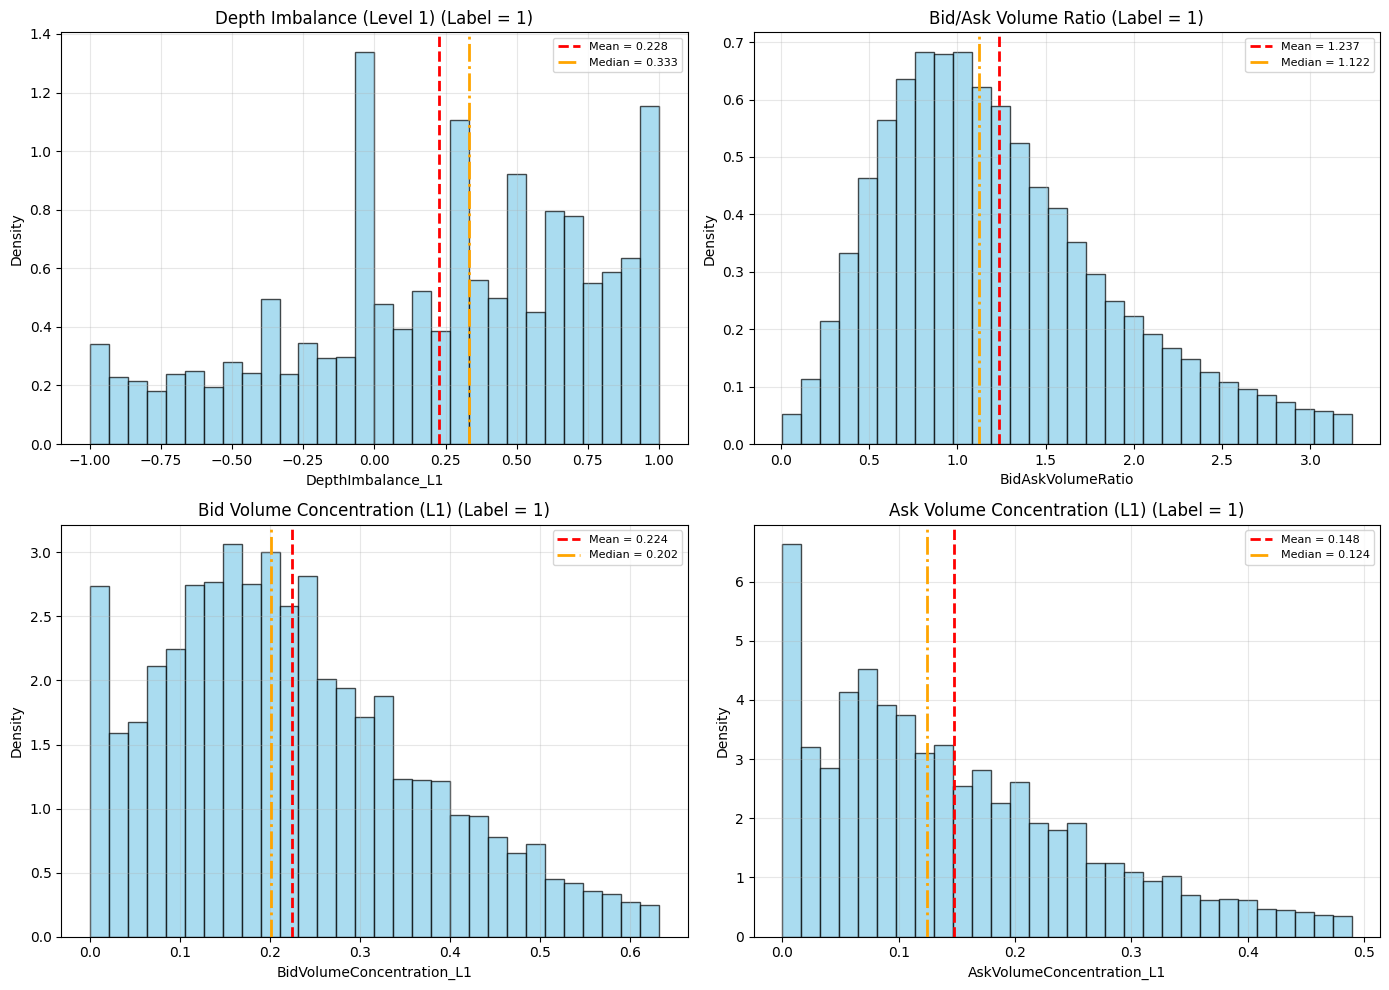

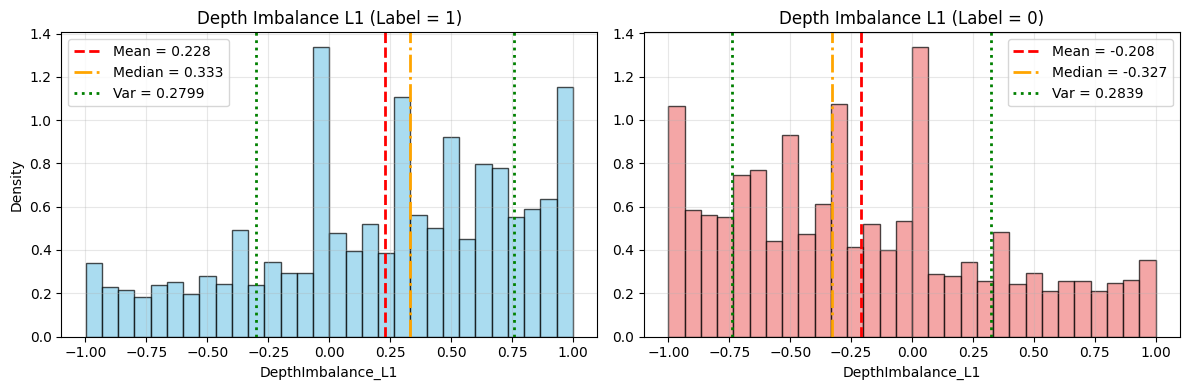

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.flatten()

features_to_plot = [
    ('DepthImbalance_L1', 'Depth Imbalance (Level 1)'),
    ('BidAskVolumeRatio', 'Bid/Ask Volume Ratio'),
    ('DepthImbalance_L4', 'Depth Imbalance (Level 4)'),
    ('BidVolumeConcentration_L1', 'Bid Volume Concentration (L1)'),
    ('BidVolumeSlope', 'Bid Volume Slope'),
    ('AskVolumeSlope', 'Ask Volume Slope')
]

for idx, (feature, title) in enumerate(features_to_plot):
    ax = axs[idx]
    
    data1 = modified_df.loc[modified_df["Label"] == 1, feature]
    data0 = modified_df.loc[modified_df["Label"] == 0, feature]
    
    ax.hist(data1, bins=30, density=True, color='skyblue', 
            edgecolor='black', alpha=0.6, label='Label = 1')
    ax.hist(data0, bins=30, density=True, color='lightcoral', 
            edgecolor='black', alpha=0.6, label='Label = 0')
    
    ax.axvline(data1.mean(), color='blue', linestyle='--', 
               linewidth=2, label=f"Mean (1) = {data1.mean():.3f}")
    ax.axvline(data0.mean(), color='red', linestyle='--', 
               linewidth=2, label=f"Mean (0) = {data0.mean():.3f}")
    
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig2, axs2 = plt.subplots(2, 2, figsize=(14, 10))

key_features = [
    ('DepthImbalance_L1', 'Depth Imbalance (Level 1)'),
    ('BidAskVolumeRatio', 'Bid/Ask Volume Ratio'),
    ('BidVolumeConcentration_L1', 'Bid Volume Concentration (L1)'),
    ('AskVolumeConcentration_L1', 'Ask Volume Concentration (L1)')
]

for idx, (feature, title) in enumerate(key_features):
    row, col = idx // 2, idx % 2
    
    data1 = modified_df.loc[modified_df["Label"] == 1, feature]
    axs2[row, col].hist(data1, bins=30, density=True, color='skyblue', 
                        edgecolor='black', alpha=0.7)
    axs2[row, col].axvline(data1.mean(), color='red', linestyle='--', 
                           linewidth=2, label=f"Mean = {data1.mean():.3f}")
    axs2[row, col].axvline(data1.median(), color='orange', linestyle='-.', 
                           linewidth=2, label=f"Median = {data1.median():.3f}")
    axs2[row, col].set_title(f"{title} (Label = 1)")
    axs2[row, col].set_xlabel(feature)
    axs2[row, col].set_ylabel("Density")
    axs2[row, col].legend(fontsize=8)
    axs2[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig3, axs3 = plt.subplots(1, 2, figsize=(12, 4))

# --- Label = 1 ---
data1 = modified_df.loc[modified_df["Label"] == 1, "DepthImbalance_L1"]
axs3[0].hist(data1, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7)
axs3[0].axvline(data1.mean(), color='red', linestyle='--', linewidth=2, 
                label=f"Mean = {data1.mean():.3f}")
axs3[0].axvline(data1.median(), color='orange', linestyle='-.', linewidth=2, 
                label=f"Median = {data1.median():.3f}")
axs3[0].axvline(data1.mean() + data1.var()**0.5, color='green', linestyle=':', 
                linewidth=2, label=f"Var = {data1.var():.4f}")
axs3[0].axvline(data1.mean() - data1.var()**0.5, color='green', linestyle=':', linewidth=2)
axs3[0].set_title("Depth Imbalance L1 (Label = 1)")
axs3[0].set_xlabel("DepthImbalance_L1")
axs3[0].set_ylabel("Density")
axs3[0].legend()
axs3[0].grid(alpha=0.3)

# --- Label = 0 ---
data0 = modified_df.loc[modified_df["Label"] == 0, "DepthImbalance_L1"]
axs3[1].hist(data0, bins=30, density=True, color='lightcoral', edgecolor='black', alpha=0.7)
axs3[1].axvline(data0.mean(), color='red', linestyle='--', linewidth=2, 
                label=f"Mean = {data0.mean():.3f}")
axs3[1].axvline(data0.median(), color='orange', linestyle='-.', linewidth=2, 
                label=f"Median = {data0.median():.3f}")
axs3[1].axvline(data0.mean() + data0.var()**0.5, color='green', linestyle=':', 
                linewidth=2, label=f"Var = {data0.var():.4f}")
axs3[1].axvline(data0.mean() - data0.var()**0.5, color='green', linestyle=':', linewidth=2)
axs3[1].set_title("Depth Imbalance L1 (Label = 0)")
axs3[1].set_xlabel("DepthImbalance_L1")
axs3[1].legend()
axs3[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Just as a quick sanity check, it's worth seeing how our features correlate to the final label. Correlation != causation but still, maybe we've extracted some useful information from the original data:

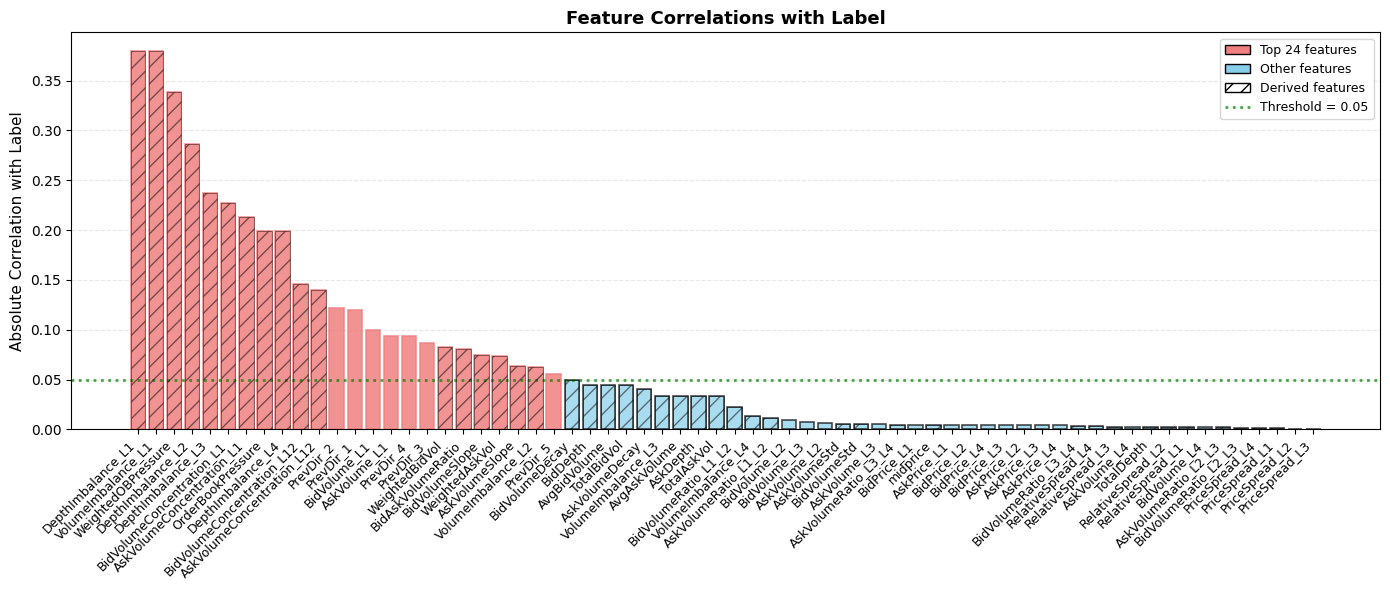

Top 10 Features by Correlation with Label:
DepthImbalance_L1             0.379498
VolumeImbalance_L1            0.379498
WeightedOBPressure            0.338859
DepthImbalance_L2             0.286925
DepthImbalance_L3             0.237708
BidVolumeConcentration_L1     0.227565
AskVolumeConcentration_L1     0.213403
OrderBookPressure             0.199462
DepthImbalance_L4             0.199462
BidVolumeConcentration_L12    0.145626
dtype: float64


In [30]:
correlations = modified_df.drop(columns=['Label']).corrwith(modified_df['Label']).abs()
correlations = correlations.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(range(len(correlations)), correlations.values,
              color='skyblue', edgecolor='black', alpha=0.7, linewidth=1.2)

top_n = 24
for i in range(min(top_n, len(bars))):
    bars[i].set_color('lightcoral')
    bars[i].set_alpha(0.85)

derived_features = {
    'midprice',
    'PriceSpread_L1','PriceSpread_L2','PriceSpread_L3','PriceSpread_L4',
    'RelativeSpread_L1','RelativeSpread_L2','RelativeSpread_L3','RelativeSpread_L4',
    'VolumeImbalance_L1','VolumeImbalance_L2','VolumeImbalance_L3','VolumeImbalance_L4',
    'TotalBidVol','TotalAskVol','OrderBookPressure',
    'WeightedBidVol','WeightedAskVol','WeightedOBPressure',
    'DepthImbalance_L1','DepthImbalance_L2','DepthImbalance_L3','DepthImbalance_L4',
    'BidAskVolumeRatio','BidVolumeConcentration_L1','AskVolumeConcentration_L1',
    'BidVolumeConcentration_L12','AskVolumeConcentration_L12',
    'TotalDepth','BidDepth','AskDepth',
    'BidVolumeDecay','AskVolumeDecay',
    'BidVolumeRatio_L1_L2','BidVolumeRatio_L2_L3','BidVolumeRatio_L3_L4',
    'AskVolumeRatio_L1_L2','AskVolumeRatio_L2_L3','AskVolumeRatio_L3_L4',
    'AvgBidVolume','AvgAskVolume','BidVolumeStd','AskVolumeStd',
    'BidVolumeSlope','AskVolumeSlope',
    'WeightedOBPressure' 
}

derived_color = 'none'
bar_width = bars[0].get_width() if len(bars) > 0 else 0.8

for idx, feature in enumerate(correlations.index):
    if feature in derived_features:
        height = correlations.values[idx]
        rect = Rectangle(
            (idx - bar_width/2, 0),        
            bar_width,                     
            height,                        
            facecolor=derived_color,       
            edgecolor='black',
            linewidth=0.6,
            alpha=0.50,                   
            hatch='//',
            zorder=bars[idx].get_zorder() + 2
        )
        ax.add_patch(rect)

# xlabels and titles
ax.set_xticks(range(len(correlations)))
ax.set_xticklabels(correlations.index, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Absolute Correlation with Label', fontsize=11)
ax.set_title('Feature Correlations with Label', fontsize=13, fontweight='bold')

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

ax.axhline(y=0.05, color='green', linestyle=':', linewidth=2,
           label='Threshold = 0.05', alpha=0.7)

handles = []
handles.append(mpatches.Patch(facecolor='lightcoral', edgecolor='black', label=f'Top {top_n} features'))
handles.append(mpatches.Patch(facecolor='skyblue', edgecolor='black', label='Other features'))
handles.append(mpatches.Patch(facecolor=derived_color, edgecolor='black', hatch='//', label='Derived features'))
handles.append(Line2D([0], [0], color='green', linestyle=':', linewidth=2, label='Threshold = 0.05', alpha=0.7))
ax.legend(handles=handles, fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()

print("Top 10 Features by Correlation with Label:")
print(correlations.head(10))

In [17]:
# Select features with correlation higher than 0.05
selected_features = correlations[correlations > 0.05].index.tolist()

print("Selected features (|corr| > 0.05):")
print(selected_features)
print(f"Number of features: {len(selected_features)}")


Selected features (|corr| > 0.05):
['DepthImbalance_L1', 'VolumeImbalance_L1', 'WeightedOBPressure', 'DepthImbalance_L2', 'DepthImbalance_L3', 'BidVolumeConcentration_L1', 'AskVolumeConcentration_L1', 'OrderBookPressure', 'DepthImbalance_L4', 'BidVolumeConcentration_L12', 'AskVolumeConcentration_L12', 'PrevDir_2', 'PrevDir_1', 'BidVolume_L1', 'AskVolume_L1', 'PrevDir_4', 'PrevDir_3', 'WeightedBidVol', 'BidAskVolumeRatio', 'BidVolumeSlope', 'WeightedAskVol', 'AskVolumeSlope', 'VolumeImbalance_L2', 'PrevDir_5']
Number of features: 24


In [18]:
# Now build X,y from the full dataset using selected features, then do a time-based split
X = modified_df[selected_features].values
y = modified_df["Label"].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))


In [ ]:
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    # Hidden layer 1: captures nonlinear feature interactions
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Hidden layer 2: deepens representation
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Hidden layer 3: compression before output
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),

    # Output layer: sigmoid for binary classification
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='AUC')])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

test_loss, test_accuracy, test_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f} | Test AUC: {test_auc:.4f}")


Epoch 1/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - AUC: 0.7411 - accuracy: 0.6799 - loss: 0.6145 - val_AUC: 0.7725 - val_accuracy: 0.6970 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 2/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.7643 - accuracy: 0.6906 - loss: 0.5890 - val_AUC: 0.7808 - val_accuracy: 0.7016 - val_loss: 0.5750 - learning_rate: 0.0010
Epoch 3/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.7703 - accuracy: 0.6962 - loss: 0.5813 - val_AUC: 0.7822 - val_accuracy: 0.7014 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 4/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.7732 - accuracy: 0.6976 - loss: 0.5770 - val_AUC: 0.7833 - val_accuracy: 0.7027 - val_loss: 0.5659 - learning_rate: 0.0010
Epoch 5/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.7743 - accuracy: 0.6980 - loss: 0.5751 - val_AUC: 0.7839 - val_accuracy: 0.7039 - val_loss: 0.5644 - learning_rate: 0.0010
Epoch 6/500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.7

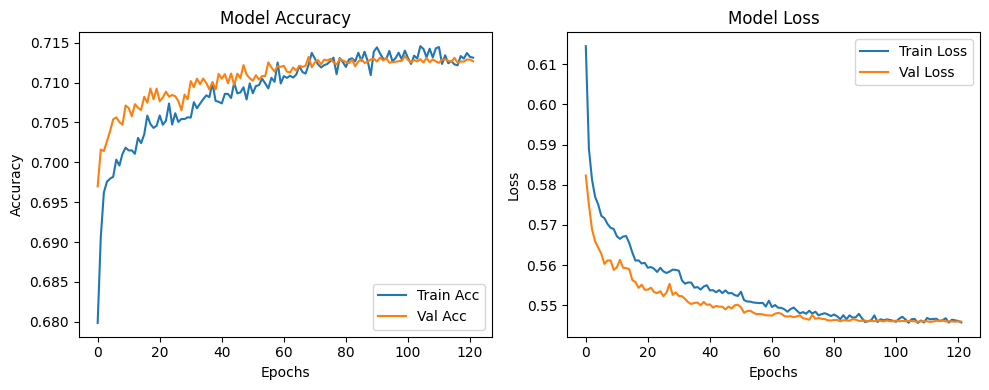

In [63]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### RNN:

In [68]:
model_RNN = tf.keras.Sequential([
    layers.Input(shape=(1,X_train_scaled.shape[1])),
    layers.GRU(64),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.132),
    layers.Dense(1, activation='sigmoid')
])

model_RNN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00309),
    loss='binary_crossentropy',
     metrics=[
        'accuracy',
        metrics.AUC(name='auc', curve='ROC')
    ]
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    verbose=1
)




Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.7730 - accuracy: 0.6973 - loss: 0.5693 - val_AUC: 0.7805 - val_accuracy: 0.7033 - val_loss: 0.5621
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.7755 - accuracy: 0.6988 - loss: 0.5666 - val_AUC: 0.7820 - val_accuracy: 0.7054 - val_loss: 0.5604
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.7759 - accuracy: 0.6996 - loss: 0.5666 - val_AUC: 0.7833 - val_accuracy: 0.7061 - val_loss: 0.5590
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.7776 - accuracy: 0.7002 - loss: 0.5643 - val_AUC: 0.7842 - val_accuracy: 0.7062 - val_loss: 0.5580
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.7796 - accuracy: 0.7025 - loss: 0.5627 - val_AUC: 0.7849 - val_accuracy: 0.7070 - val_loss: 0.5571
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - AUC: 0.7798 - accuracy: 0.7018 - loss: 0.5626 - val_AUC: 0.7862 - val_accuracy: 0.7077 - val_loss: 0.5557
Epoch 7/100
1563/1563 

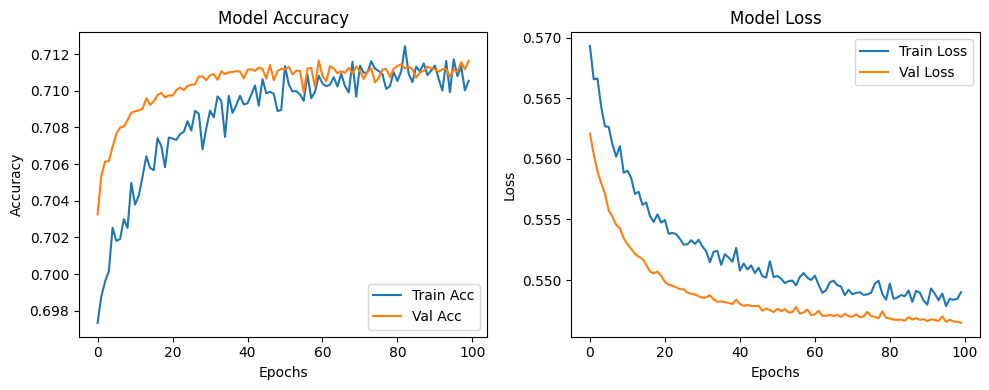

In [69]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Finally, predictions:

In [73]:

test_columns = [                              # 1. Midprice change direction
    "AskPrice_L1", "AskVolume_L1",          # 2–3. Sell level 1
    "BidPrice_L1", "BidVolume_L1",          # 4–5. Buy level 1
    "AskPrice_L2", "AskVolume_L2",          # 6–7. Sell level 2
    "BidPrice_L2", "BidVolume_L2",          # 8–9. Buy level 2
    "AskPrice_L3", "AskVolume_L3",          # 10–11. Sell level 3
    "BidPrice_L3", "BidVolume_L3",          # 12–13. Buy level 3
    "AskPrice_L4", "AskVolume_L4",          # 14–15. Sell level 4
    "BidPrice_L4", "BidVolume_L4",          # 16–17. Buy level 4
    "PrevDir_1", "PrevDir_2", "PrevDir_3", "PrevDir_4", "PrevDir_5"  # 18–22. Previous directions
]

test = pd.read_csv("./DL-2025-CW-data/Data_B_nolabels.csv", header=None, names=test_columns)
test.head()

,AskPrice_L1,AskVolume_L1,BidPrice_L1,BidVolume_L1,AskPrice_L2,AskVolume_L2,BidPrice_L2,BidVolume_L2,AskPrice_L3,AskVolume_L3,...,BidVolume_L3,AskPrice_L4,AskVolume_L4,BidPrice_L4,BidVolume_L4,PrevDir_1,PrevDir_2,PrevDir_3,PrevDir_4,PrevDir_5
0,650900.0,51,650700.0,12,651000.0,196,650600.0,100,651100.0,25,...,190,651200.0,153,650400.0,110,1,1,1,1,0
1,696400.0,16,696000.0,12,696500.0,57,695900.0,118,696600.0,100,...,262,696700.0,150,695700.0,104,1,0,1,0,1
2,740800.0,2,740400.0,20,741000.0,60,740200.0,27,741200.0,156,...,31,741300.0,200,740000.0,170,0,1,0,0,1
3,730900.0,1,730200.0,230,731000.0,111,730100.0,86,731100.0,42,...,136,731200.0,100,729900.0,132,1,1,0,0,1
4,630600.0,100,630300.0,69,630700.0,110,630200.0,2,630800.0,219,...,1,630900.0,101,630000.0,104,0,1,0,0,0


### We have to recreate only the features used in the end:

In [78]:
selected_features

['DepthImbalance_L1',
 'VolumeImbalance_L1',
 'WeightedOBPressure',
 'DepthImbalance_L2',
 'DepthImbalance_L3',
 'BidVolumeConcentration_L1',
 'AskVolumeConcentration_L1',
 'OrderBookPressure',
 'DepthImbalance_L4',
 'BidVolumeConcentration_L12',
 'AskVolumeConcentration_L12',
 'PrevDir_2',
 'PrevDir_1',
 'BidVolume_L1',
 'AskVolume_L1',
 'PrevDir_4',
 'PrevDir_3',
 'WeightedBidVol',
 'BidAskVolumeRatio',
 'BidVolumeSlope',
 'WeightedAskVol',
 'AskVolumeSlope',
 'VolumeImbalance_L2',
 'PrevDir_5']

In [ ]:
test_modified = test.copy()

test_modified["midprice"] = (test["AskPrice_L1"] + test["BidPrice_L1"]) / 2

# ------------------------- SELECTED BASIC FEATURES ---------------------- #
# VolumeImbalance for L1 and L2 (from selected features)
for i in [1, 2]:
    test_modified[f'VolumeImbalance_L{i}'] = (
        (test[f'BidVolume_L{i}'] - test[f'AskVolume_L{i}']) / 
        (test[f'BidVolume_L{i}'] + test[f'AskVolume_L{i}'])
    )

# ------------------------- ORDER BOOK PRESSURE ---------------------- #
bid_vol_cols = [f"BidVolume_L{i}" for i in range(1, 5)]
ask_vol_cols = [f"AskVolume_L{i}" for i in range(1, 5)]
test_modified["TotalBidVol"] = test[bid_vol_cols].sum(axis=1)
test_modified["TotalAskVol"] = test[ask_vol_cols].sum(axis=1)

# OrderBookPressure
test_modified["OrderBookPressure"] = (
    (test_modified["TotalBidVol"] - test_modified["TotalAskVol"]) /
    (test_modified["TotalBidVol"] + test_modified["TotalAskVol"])
).fillna(0)

# Weighted Order Book Pressure
weights = [0.6, 0.25, 0.1, 0.05]
test_modified["WeightedBidVol"] = sum(test_modified[f"BidVolume_L{i}"] * w for i, w in enumerate(weights, 1))
test_modified["WeightedAskVol"] = sum(test_modified[f"AskVolume_L{i}"] * w for i, w in enumerate(weights, 1))
test_modified["WeightedOBPressure"] = (
    (test_modified["WeightedBidVol"] - test_modified["WeightedAskVol"]) /
    (test_modified["WeightedBidVol"] + test_modified["WeightedAskVol"])
).fillna(0)

# ------------------------- DEPTH IMBALANCE ---------------------- #
# DepthImbalance for L1, L2, L3, L4 (all selected)
for k in range(1, 5):
    cum_bid = sum([test_modified[f'BidVolume_L{level}'] for level in range(1, k+1)])
    cum_ask = sum([test_modified[f'AskVolume_L{level}'] for level in range(1, k+1)])
    test_modified[f'DepthImbalance_L{k}'] = (cum_bid - cum_ask) / (cum_bid + cum_ask)

# ------------------------- VOLUME CONCENTRATION ---------------------- #
total_bid_volume = test_modified["TotalBidVol"]
total_ask_volume = test_modified["TotalAskVol"]

test_modified['BidVolumeConcentration_L1'] = test_modified['BidVolume_L1'] / total_bid_volume
test_modified['AskVolumeConcentration_L1'] = test_modified['AskVolume_L1'] / total_ask_volume

bid_vol_12 = test_modified['BidVolume_L1'] + test_modified['BidVolume_L2']
ask_vol_12 = test_modified['AskVolume_L1'] + test_modified['AskVolume_L2']
test_modified['BidVolumeConcentration_L12'] = bid_vol_12 / total_bid_volume
test_modified['AskVolumeConcentration_L12'] = ask_vol_12 / total_ask_volume

# ------------------------- BID/ASK VOLUME RATIO ---------------------- #
test_modified['BidAskVolumeRatio'] = total_bid_volume / total_ask_volume

# ------------------------- VOLUME SLOPE ---------------------- #
test_modified['BidVolumeSlope'] = (test_modified['BidVolume_L4'] - test_modified['BidVolume_L1']) / 3
test_modified['AskVolumeSlope'] = (test_modified['AskVolume_L4'] - test_modified['AskVolume_L1']) / 3

# ------------------------- EXTRACT ONLY SELECTED FEATURES ---------------------- #
selected_features = [
    'DepthImbalance_L1', 'VolumeImbalance_L1', 'WeightedOBPressure', 
    'DepthImbalance_L2', 'DepthImbalance_L3', 'BidVolumeConcentration_L1', 
    'AskVolumeConcentration_L1', 'OrderBookPressure', 'DepthImbalance_L4', 
    'BidVolumeConcentration_L12', 'AskVolumeConcentration_L12', 'PrevDir_2', 
    'PrevDir_1', 'BidVolume_L1', 'AskVolume_L1', 'PrevDir_4', 'PrevDir_3', 
    'WeightedBidVol', 'BidAskVolumeRatio', 'BidVolumeSlope', 'WeightedAskVol', 
    'AskVolumeSlope', 'VolumeImbalance_L2', 'PrevDir_5'
]

test_features = test_modified[selected_features]
print(f"\nShape: {test_features.shape}")


Shape: (20000, 24)


In [96]:
test_features_scaled = scaler.transform(test_features.values)

preds_FNN = model.predict(test_features_scaled)

test_features_reshaped = test_features_scaled.reshape(test_features_scaled.shape[0], 1, test_features_scaled.shape[1])
preds_RNN = model_RNN.predict(test_features_reshaped)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


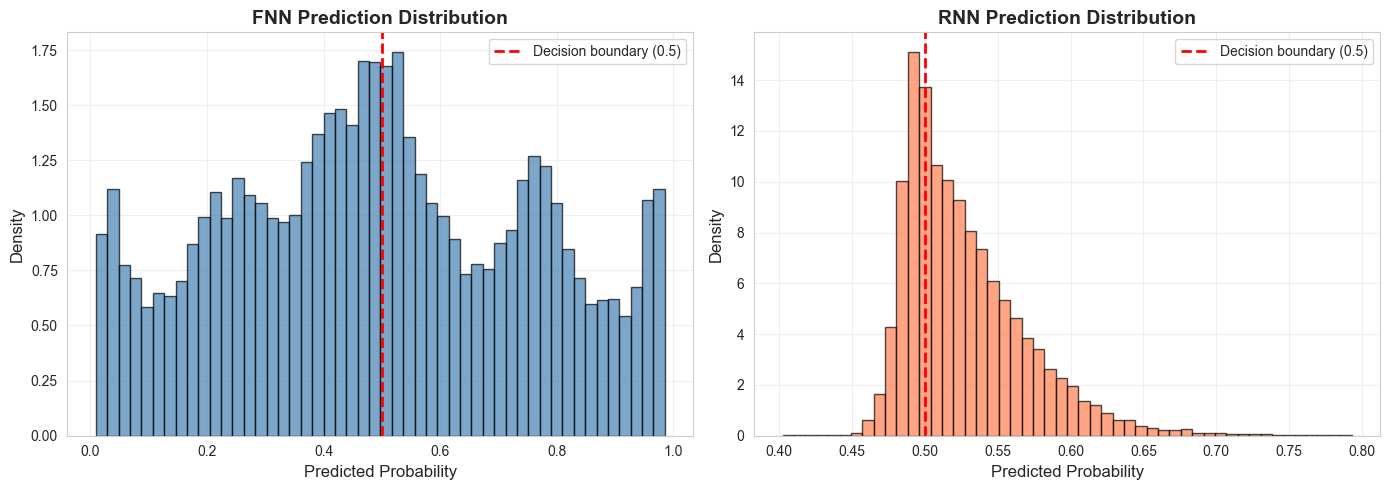

FNN Predictions Summary:
Mean: 0.4924
Median: 0.4847
Std: 0.2581
Min: 0.0093
Max: 0.9858
Predictions > 0.5: 9485 (47.42%)

RNN Predictions Summary:
Mean: 0.5275
Median: 0.5176
Std: 0.0420
Min: 0.4025
Max: 0.7928
Predictions > 0.5: 13827 (69.14%)


In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(preds_FNN, bins=50, alpha=0.7, color='steelblue', edgecolor='black', density=True)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision boundary (0.5)')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('FNN Prediction Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(preds_RNN, bins=50, alpha=0.7, color='coral', edgecolor='black', density=True)
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision boundary (0.5)')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('RNN Prediction Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("FNN Predictions Summary:")
print("="*60)
print(f"Mean: {preds_FNN.mean():.4f}")
print(f"Median: {np.median(preds_FNN):.4f}")
print(f"Std: {preds_FNN.std():.4f}")
print(f"Min: {preds_FNN.min():.4f}")
print(f"Max: {preds_FNN.max():.4f}")
print(f"Predictions > 0.5: {(preds_FNN > 0.5).sum()} ({(preds_FNN > 0.5).mean()*100:.2f}%)")
print()
print("="*60)
print("RNN Predictions Summary:")
print("="*60)
print(f"Mean: {preds_RNN.mean():.4f}")
print(f"Median: {np.median(preds_RNN):.4f}")
print(f"Std: {preds_RNN.std():.4f}")
print(f"Min: {preds_RNN.min():.4f}")
print(f"Max: {preds_RNN.max():.4f}")
print(f"Predictions > 0.5: {(preds_RNN > 0.5).sum()} ({(preds_RNN > 0.5).mean()*100:.2f}%)")

## Observations:

### FNN:
- **Wide distribution** (std: 0.2581) spanning nearly the full [0, 1] range
- **Balanced predictions**: 47.42% predict class 1 (> 0.5)
- **Confident differentiation**: Model makes diverse predictions across [0, 1]
- **Variance**: Model has learned to distinguish between different samples

### RNN:
- **Extremely narrow distribution** (std: 0.0420). Bad sign
- **Clustered around 0.5-0.52**: Almost all predictions fall in a tiny range
- **69.14% predict class 1**, but barely. most are just slightly above 0.5
- **Lacks confidence**: The model is essentially saying "I'm not sure" for almost everything

In [103]:
final_preds =(preds_FNN > 0.5).astype(int).flatten()
final_preds

array([0, 0, 1, ..., 0, 1, 0], shape=(20000,))

In [ ]:
print(f"Number of predictions: {len(final_preds)}")
print(f"Class distribution: {np.bincount(final_preds)}")
print(f"Class 0: {(final_preds == 0).sum()} ({(final_preds == 0).mean()*100:.2f}%)")
print(f"Class 1: {(final_preds == 1).sum()} ({(final_preds == 1).mean()*100:.2f}%)")

Number of predictions: 20000
Class distribution: [10515  9485]
Class 0: 10515 (52.58%)
Class 1: 9485 (47.42%)


In [ ]:
CID = ""  
surname = ""

filename = f"{CID}_{surname}.txt"

np.savetxt(filename, final_preds, fmt='%d')

print(f"\nPredictions saved to: {filename}")

print("\nFirst 10 lines of the output file:")
with open(filename, 'r') as f:
    for i, line in enumerate(f):
        if i < 10:
            print(line.strip())
        else:
            break


Predictions saved to: 01234567_YourSurname.txt

First 10 lines of the output file:
0
0
1
1
0
0
0
0
1
0
